In [179]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [180]:
data = pd.read_csv("data/sp500_stocks.csv")
data=data[data['Symbol']=='MMM']
data.drop(['Symbol'], axis=1, inplace=True)
data=data[['Date','Close']]
date_column='Date'
target_column='Close'
data

,Date,Close
0,2010-01-04,69.414719
1,2010-01-05,68.979935
2,2010-01-06,69.958191
3,2010-01-07,70.008362
4,2010-01-08,70.501671
...,...,...
3605,2024-05-01,98.440002
3606,2024-05-02,96.809998
3607,2024-05-03,97.150002
3608,2024-05-06,96.589996


## Pre Processing

In [181]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3610 entries, 0 to 3609
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3610 non-null   object 
 1   Close   3610 non-null   float64
dtypes: float64(1), object(1)
memory usage: 84.6+ KB


In [182]:
data.dropna(inplace=True)
data.isna().sum()

Date     0
Close    0
dtype: int64

In [183]:
data.describe()

,Close
count,3610.000000
mean,120.209173
std,36.686544
min,59.306019
25%,84.456520
50%,123.143814
75%,147.380848
max,216.245819


## Stationary Check

Data is not Stationary pValue of adfuller test is : 0.45022224917797526


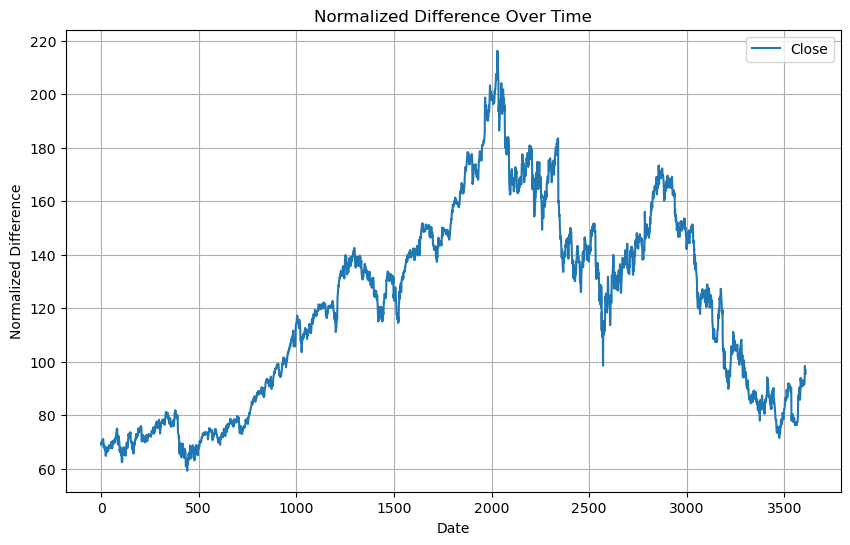

In [184]:
from statsmodels.tsa.stattools import adfuller
adftest=adfuller(data[target_column])
if adftest[1] <0.05:
    print('Data is Stationary pValue of adfuller test is :',adftest[1])
else:
    print('Data is not Stationary pValue of adfuller test is :',adftest[1])
    
    
plt.figure(figsize=(10, 6))
plt.plot(data.index, data[target_column], label=target_column)

plt.xlabel('Date')
plt.ylabel('Normalized Difference')
plt.title('Normalized Difference Over Time')
plt.legend()
plt.grid(True)
plt.show()

### Differencing

pValue of adfuller test is : 6.5737760270656635e-22


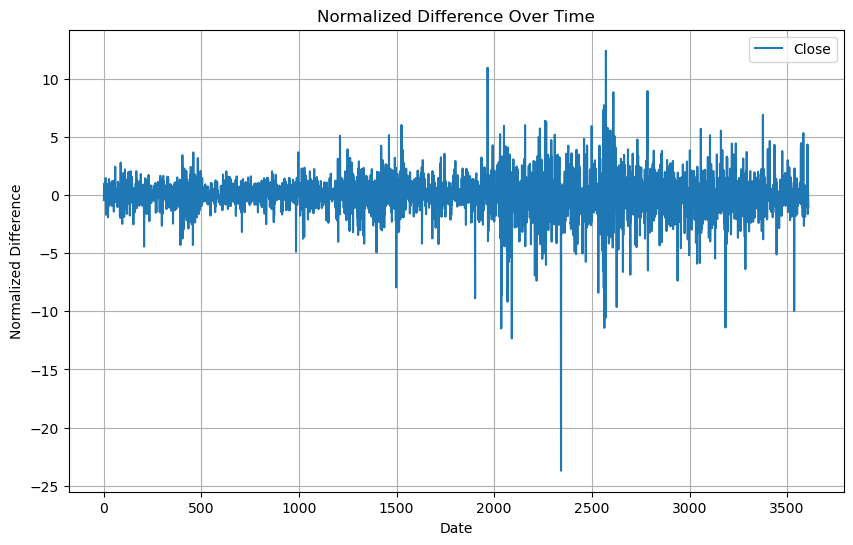

,Date,Close,Close_Diff
0,2010-01-04,69.414719,NaN
1,2010-01-05,68.979935,-0.434784
2,2010-01-06,69.958191,0.978256
3,2010-01-07,70.008362,0.050171
4,2010-01-08,70.501671,0.493309
...,...,...,...
3605,2024-05-01,98.440002,1.930000
3606,2024-05-02,96.809998,-1.630005
3607,2024-05-03,97.150002,0.340004
3608,2024-05-06,96.589996,-0.560005


In [185]:
normalized_difference=data.copy()
normalized_difference['Close_Diff'] = normalized_difference[target_column].diff()
normalized_difference.dropna(inplace=True)
adftest=adfuller(normalized_difference['Close_Diff'])
print('pValue of adfuller test is :',adftest[1])
plt.figure(figsize=(10, 6))
plt.plot(normalized_difference.index, normalized_difference['Close_Diff'], label=target_column)

plt.xlabel('Date')
plt.ylabel('Normalized Difference')
plt.title('Normalized Difference Over Time')
plt.legend()
plt.grid(True)
plt.show()
data['Close_Diff']=normalized_difference['Close_Diff']
data

### Logarithim

pValue of adfuller test is : 0.42392422262787716


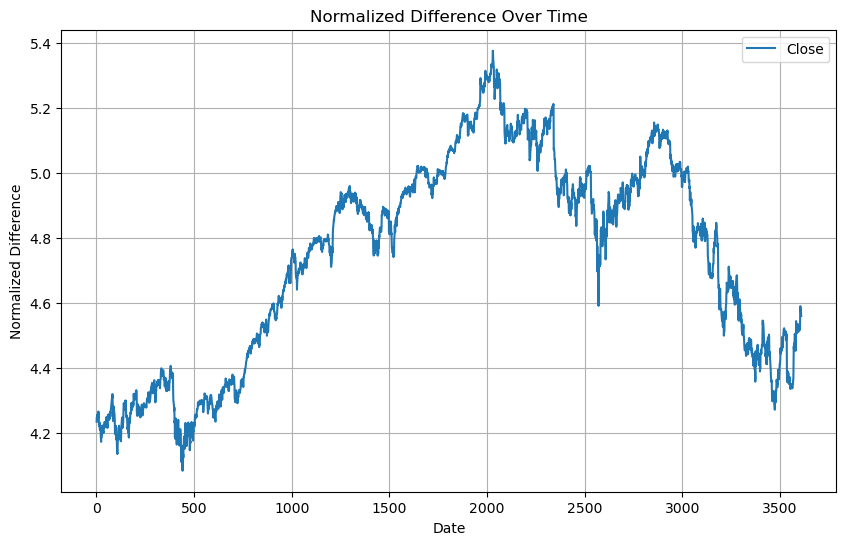

,Date,Close,Close_Diff,Close_Log
1,2010-01-05,68.979935,-0.434784,4.233816
2,2010-01-06,69.958191,0.978256,4.247898
3,2010-01-07,70.008362,0.050171,4.248615
4,2010-01-08,70.501671,0.493309,4.255636
5,2010-01-11,70.217392,-0.284279,4.251596
...,...,...,...,...
3605,2024-05-01,98.440002,1.930000,4.589447
3606,2024-05-02,96.809998,-1.630005,4.572750
3607,2024-05-03,97.150002,0.340004,4.576256
3608,2024-05-06,96.589996,-0.560005,4.570475


In [186]:
normalized_log=data
normalized_log['Close_Log'] = normalized_log[target_column].apply(lambda x: np.log(x) if x != 0 else 0)
adftest=adfuller(normalized_log['Close_Log'])
print('pValue of adfuller test is :',adftest[1]) 
normalized_log.dropna(inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(normalized_log.index, normalized_log['Close_Log'], label=target_column)

plt.xlabel('Date')
plt.ylabel('Normalized Difference')
plt.title('Normalized Difference Over Time')
plt.legend()
plt.grid(True)
plt.show()
data['Close_Log']=normalized_log['Close_Log']
data

### Breakdown for Stationary Data
Upon testing both difference and logarithmic method i have choosen Loagrithem method because the p value is less then 0.05

In [187]:
scaler = MinMaxScaler()
close_column = data['Close_Diff'].values.reshape(-1, 1)
close_column_log =data['Close_Log'].values.reshape(-1, 1)
close_normalized = scaler.fit_transform(close_column)
close_normalized_log = scaler.fit_transform(close_column_log)
data['Close_Diff'] = close_normalized
data['Close_Log'] = close_normalized_log




In [188]:
data

,Date,Close,Close_Diff,Close_Log
1,2010-01-05,68.979935,0.644295,0.116800
2,2010-01-06,69.958191,0.683406,0.127685
3,2010-01-07,70.008362,0.657718,0.128239
4,2010-01-08,70.501671,0.669984,0.133667
5,2010-01-11,70.217392,0.648461,0.130544
...,...,...,...,...
3605,2024-05-01,98.440002,0.709750,0.391694
3606,2024-05-02,96.809998,0.611213,0.378788
3607,2024-05-03,97.150002,0.665740,0.381498
3608,2024-05-06,96.589996,0.640829,0.377029


In [189]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data_final= data.groupby(['Year', 'Month']).mean()
data_final

Close  Close_Diff  Close_Log
Year Month                                  
2010 1      69.394277    0.653077   0.121332
     2      66.802940    0.655915   0.091948
     3      68.392467    0.659771   0.110140
     4      71.349340    0.661950   0.142712
     5      69.780935    0.645499   0.125201
...               ...         ...        ...
2024 1      86.860169    0.639832   0.293593
     2      77.616639    0.653749   0.207922
     3      84.071907    0.672472   0.268305
     4      92.267728    0.666171   0.341570
     5      96.906000    0.650960   0.379518

[173 rows x 3 columns]

In [190]:
adftest=adfuller(data['Close_Log'])
print('pValue of adfuller test is :',adftest[1]) 
adftest=adfuller(data['Close_Diff'])
print('pValue of adfuller test is :',adftest[1]) 

pValue of adfuller test is : 0.4229836731853425
pValue of adfuller test is : 6.573776027065051e-22


## Arima Model

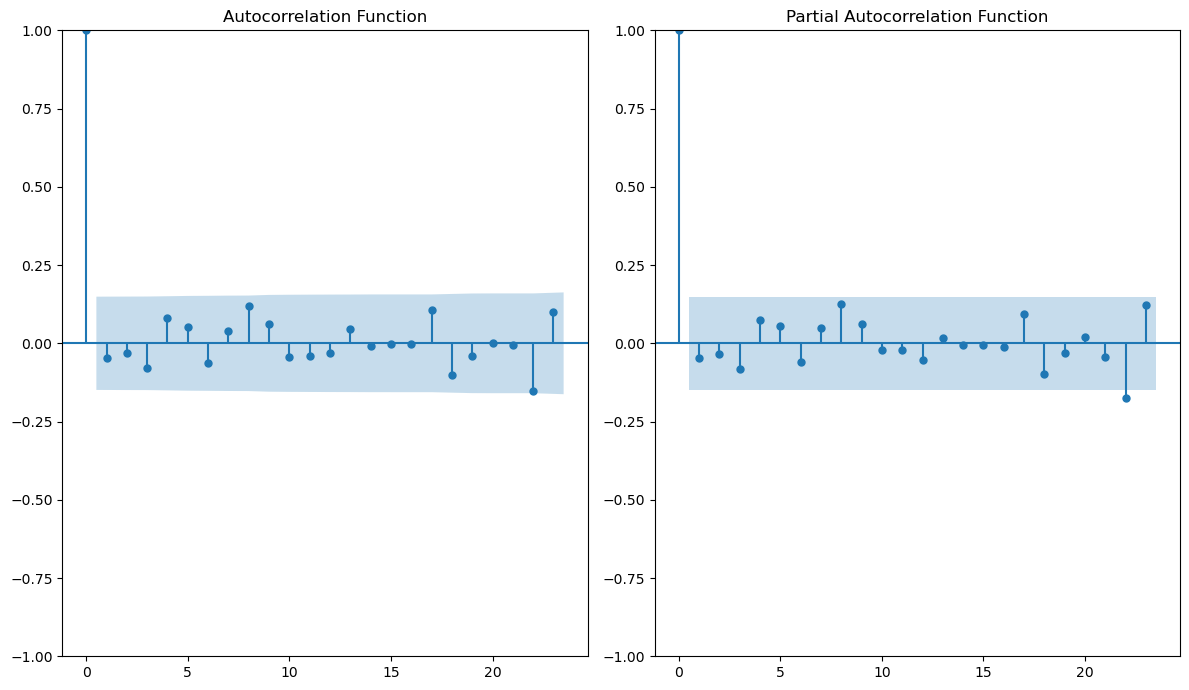

In [193]:
y = data_final['Close_Diff']
lag_acf = acf(y, nlags=25)
lag_pacf = pacf(y, nlags=25, method='ols')
plt.figure(figsize=(12, 7))
plt.subplot(121)
plot_acf(y, ax=plt.gca())
plt.title('Autocorrelation Function')
plt.subplot(122)
plot_pacf(y, ax=plt.gca())
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()


In [198]:
dummy=data_final.copy()
print('Results of Dickey-Fuller Test:')
dftest = adfuller(dummy['Close_Diff'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print("Adfuller Output")
dfoutput

Results of Dickey-Fuller Test:
Adfuller Output


Test Statistic                -1.365779e+01
p-value                        1.541901e-25
#Lags Used                     0.000000e+00
Number of Observations Used    1.720000e+02
dtype: float64

## Splitting

In [200]:
train_size = int(len(data_final) * 0.8)
train_data, test_data = data_final['Close_Diff'][:train_size], data_final['Close_Diff'][train_size:]

p = 22
d =  1
q = 22
modelAr = ARIMA(train_data, order=(p, d, q))
modelAr_fit = modelAr.fit()

# Make forecasts
forecast_steps = len(test_data)
forecast = modelAr_fit.forecast(steps=forecast_steps)

# Calculate RMSE
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
print('Root Mean Squared Error (RMSE):', rmse)

NameError: name 'final_data' is not defined

In [93]:
model = ARIMA(train['Close'], order=(1, 2, 0))
arima_result = model.fit()
predictions_arima = arima_result.predict(start=test.index[0], end=test.index[-1])



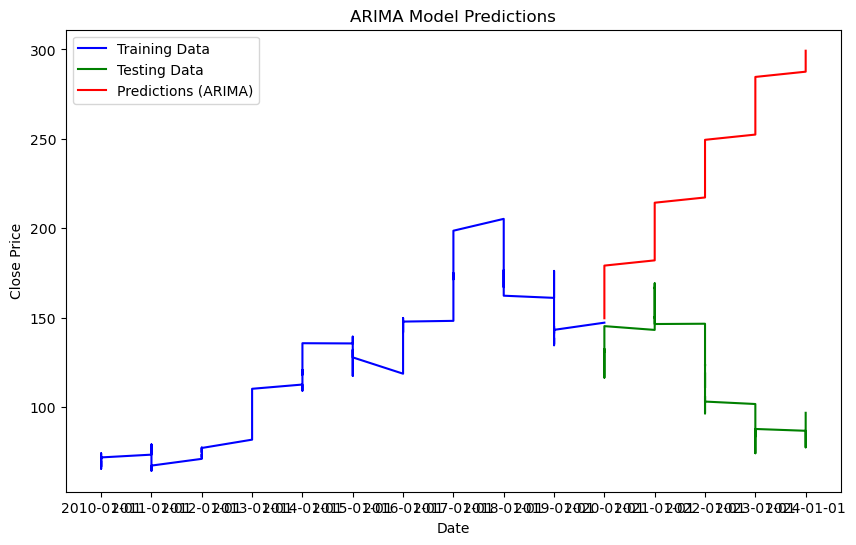

ARIMA Performance Metrics (Testing Set):
R-squared: -17.972755061486072
RMSE: 124.15863772991703
MAE: 103.95521247342913
MAPE: 107.166529677557


In [94]:
plt.figure(figsize=(10, 6))
plt.plot(train['Date'], train['Close'], label='Training Data', color='blue')
plt.plot(test['Date'], test['Close'], label='Testing Data', color='green')
plt.plot(test['Date'], predictions_arima, label='Predictions (ARIMA)', color='red')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


predictions_arima_aligned = predictions_arima[:-1]

# Calculate evaluation metrics based on the testing set
rmse_arima = np.sqrt(mean_squared_error(test['Close'].iloc[1:], predictions_arima_aligned))
mae_arima = mean_absolute_error(test['Close'].iloc[1:], predictions_arima_aligned)
mape_arima = np.mean(np.abs((test['Close'].iloc[1:] - predictions_arima_aligned) / test['Close'].iloc[1:])) * 100
r_squared = r2_score(test['Close'].iloc[1:], predictions_arima_aligned)

# Print ARIMA performance metrics based on the testing set
print("ARIMA Performance Metrics (Testing Set):")
print("R-squared:", r_squared)
print("RMSE:", rmse_arima)
print("MAE:", mae_arima)
print("MAPE:", mape_arima)

In [26]:
# from tqdm import tqdm
# # Define a function to perform grid search
# def grid_search_ARIMA(y, p_values, d_values, q_values):
#     best_score = float('inf')
#     best_order = None
    
#     for p in tqdm(p_values, desc='Progress', position=0):
#         for d in d_values:
#             for q in q_values:
#                 order = (p, d, q)
#                 try:
#                     arima_model = ARIMA(y, order=order)
#                     arima_result = arima_model.fit()
#                     predictions = arima_result.predict()
#                     score = mean_absolute_error(y, predictions)
#                     if score < best_score:
#                         best_score = score
#                         best_order = order
#                 except:
#                     continue
    
#     return best_order, best_score

# p_values = range(0, 20)
# d_values = range(0, 5)
# q_values = range(0, 5)

# # Perform grid search
# best_order, best_score = grid_search_ARIMA(y, p_values, d_values, q_values)
# print("Best ARIMA Order:", best_order)
# print("Best MAE Score:", best_score)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [08:52<00:00, 26.63s/it]

Best ARIMA Order: (18, 0, 3)
Best MAE Score: 0.013067150615045956


# ANN

In [31]:
X = normalized_df[date_column]
y = normalized_df[target_column]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
input_dim = X.shape[0]
model = Sequential()
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)




Epoch 1/5


ValueError: in user code:

    File "C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 172, but received input with shape (None, 1)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=string)
      • training=True
      • mask=None


In [35]:
X.shape

(172,)